# Counterfactual functionality of [polis.basis.ai](http://polis.basis.ai/)

In [63]:
import os
import logging
import matplotlib.pyplot as plt
import dill
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
import seaborn as sns


import networkx as nx
import matplotlib.pyplot as plt

import plotly.express as px
import numpy as np
import plotly.graph_objects as go

from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features, list_interventions, list_outcomes, find_repo_root)
from cities.queries.causal_insight_slim import CausalInsightSlim as CausalInsight
root = find_repo_root()

Suppose you're interested in the impact of the Department of Commerce funding on the unemployment rate. Assume further that you're particularly interested in the fate of Northwest Arctic Borough, AK and what this county has potentially to gain from such funding. Say we want to estimate the causal role such a funding could have had if received in 2016. (this is because we can only fairly reliably estimate three years ahead, and we want to end the estimation period before the Covid pandemic, to avoid complications in the discussion of the result). Since you know it is unreasonable to expect such funding to have immediate impact, you allow for a one year of "grace period" and look at the outcome in 2018. The first thing you can you is load the data:

In [65]:
outcome='unemployment_rate'
intervention='spending_commerce'
forward_shift = 2

dg = DataGrabber()
dg.get_features_wide([outcome, intervention])

display(
dg.wide[intervention].head(),
dg.wide[outcome].head()
)

,GeoFIPS,GeoName,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,2364930.0,0.0,0.0,0.0,0.0
1,1003,"Baldwin, AL",0.0,1274298.0,0.0,186580.0,105434.0,105434.0,846583.0,0.0,1589502.0,50000.0,0.0,800000.0
2,1005,"Barbour, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1994425.0
3,1007,"Bibb, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1009,"Blount, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,GeoFIPS,GeoName,1990,1991,1992,1993,1994,1995,1996,1997,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,1001,"Autauga County, AL",6.5,6.8,6.5,5.9,5.0,5.6,3.9,3.9,...,6.3,5.8,5.2,5.1,4.0,3.6,2.9,5.3,2.8,2.3
1,1003,"Baldwin County, AL",5.3,5.5,6.3,5.9,4.8,4.7,4.4,3.5,...,6.7,6.1,5.6,5.4,4.2,3.6,2.9,6.1,2.9,2.4
2,1005,"Barbour County, AL",7.9,8.7,10.7,10.0,6.4,8.2,9.5,7.3,...,10.4,10.5,8.9,8.4,6.0,5.1,4.0,7.7,5.5,4.1
3,1007,"Bibb County, AL",9.2,11.8,11.1,11.5,7.7,6.5,7.1,7.4,...,8.0,7.2,6.7,6.5,4.5,4.0,3.3,7.3,3.4,2.5
4,1009,"Blount County, AL",6.4,5.8,6.2,5.2,4.2,4.4,3.3,3.0,...,6.4,6.1,5.4,5.4,4.1,3.5,2.8,4.5,2.4,2.2


Your first stab might be to select those counties which received no funding and compare them to those that receive a decent amount thereof, say above $1B. You visualize the comparison using a boxplot. 

In [66]:
#Northwest Arctic Borough, AK, fips = 2188

int_data = dg.wide[intervention]['2016']
out_data = dg.wide[outcome]['2018']

unfunded_mask = (int_data <= 0)
moderately_funded_mask = ((int_data > 1*1e8))
unfunded_data = out_data[unfunded_mask]
unfunded_fips_2188_mask = dg.wide[outcome]['GeoFIPS'][unfunded_mask] == 2188
moderately_data = out_data[moderately_funded_mask]
false_array = np.tile(False, len(moderately_data))

df = pd.DataFrame({
    'Group': ['no funding'] * len(unfunded_data) + ['$1B < funding'] *
    len(moderately_data),
    'out_data': np.concatenate([unfunded_data, moderately_data]),
   'North Arctic Borough, AK': np.concatenate([unfunded_fips_2188_mask, false_array])
})  


fig = px.box(df, x='Group', y='out_data', points='all', color = 'North Arctic Borough, AK',
             title='The unfunded vs. the funded (2016 vs. 2018)')
mean_unfunded = unfunded_data.mean()
mean_moderately = moderately_data.mean()
fig.add_annotation(x= 0.3, y=mean_unfunded, text=f'Mean: {mean_unfunded:.2f}', showarrow=False)
fig.add_annotation(x= 0.26, y=13.5, text='North Arctic Borough, AK', font=dict(size=10, color='red'), showarrow=False)
fig.add_annotation(x= 1.3, y=mean_moderately, text=f'Mean: {mean_moderately:.2f}', showarrow=False)
fig.update_layout(template='presentation')
fig.update_layout(showlegend=False)
fig.show()


You also vaguely recall from your stats class that you might try to quantify this impact using a linear model, so this is what you try to do:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


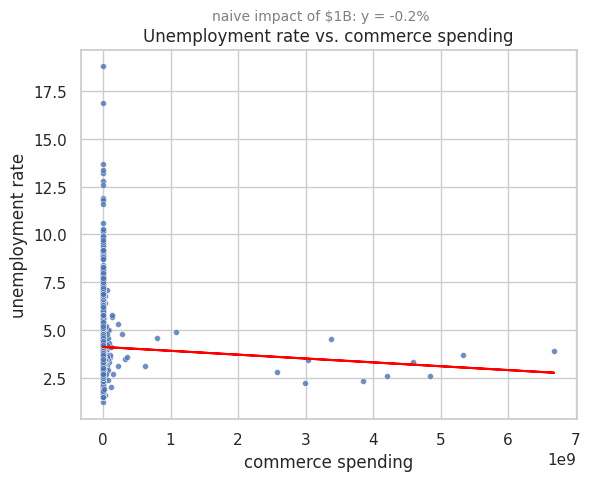

In [68]:

regression_line = np.polyfit(int_data, out_data, 1)
regression_fn = np.poly1d(regression_line)
line_values = regression_fn(int_data)
line_equation = f"naive impact of $1B: y = {round(regression_line[0] * 1e9, 2)}%"

sns.set(style="whitegrid")
sns.scatterplot(x=int_data, y=out_data, alpha=0.8, s=18)
plt.plot(int_data, line_values, color='red')
plt.suptitle(line_equation, y=0.95, fontsize=10, ha='center', va='center', color='gray')

plt.xlabel('commerce spending')
plt.ylabel('unemployment rate')
plt.title('Unemployment rate vs. commerce spending')

plt.legend().set_visible(False)
plt.show()


You visual/linear-model-based intuitions might be two-fold. 
1) You would expect on average a drop of .45% between the groups, perhaps expecting a drop of .2% per 1B funding.
2) You might think that while the average drop isn't huge, it seems that receiving the funding protects places from really bad outcomes, as you notice that no county in the funded group had unemployment above 5.8.

The question is, even if this insight is right (spoiler: it isn't), what does it tell you about whether Northwest Arctic Borough should fight (or should've fought) for such funding? In 2016 the unemployment rate there was 12.8% - so, which is it, should you expect a drop of, say, .6% if you get around $3B funding, or should you expect to be protected from the extreme outcomes and hope for an outcome closer to 6%?

There are, however, reasons to think that this way of thinking is a bit too hasty. The key problem is that neither U.S. Department of Commerce funding, nor unemployment arise in vacuum. For one thing, obviously, various covariates should be paid attention to, and their use might lead to more precise predictions that would take the specific circumstances of this county into consideration. The problem is deeper though: the protection effect that you think you see might simply arise because the places with high unemployment are under-staffed, under-funded or for some reasons ineligible for the department of commerce funding. The problem then is that the funded places more or less self-selected because some of their covariates caused the unfunded places to remain unfunded. You need to pay attention not only to covariates but also to the causal structure of the problem. This is what our model does, insofar as general application to all intput-output combinations permits.

For one thing, we divide all features into intervention time series, outcome time series and covariates, which are usually either average data from a few years or data that were only available from a particular point in time but are not expected to change in time very much (see your data guide for details). Our models use the covariates as well.

In [ ]:
features = list_available_features()
tensed_features = list_tensed_features()
interventions = list_interventions()
outcomes = list_outcomes()

covariates = [
        var
        for var in list_available_features()
        if var
        not in tensed_features 
    ]

print("covariates:", covariates)
print("interventions:", interventions)
print("outcomes", outcomes)

In [41]:
ci = CausalInsight(
    outcome_dataset=outcome,
    intervention_dataset=intervention,
    num_samples=1000,
)

percent_calc = ci.slider_values_to_interventions(intervened_percent=50, year = 2016)
ci.get_tau_samples()

fips = 2188
ci.get_fips_predictions(intervened_value= percent_calc['intervened_transformed'],
                         fips=fips, year = 2016)

ci.plot_predictions(range_multiplier=1,scaling="original")


In [47]:
from cities.modeling.model_interactions import model_cities_interaction

model_cities_interaction

<function cities.modeling.model_interactions.model_cities_interaction(N_t, N_cov, N_s, N_u, state_index, unit_index, leeway=0.9)>

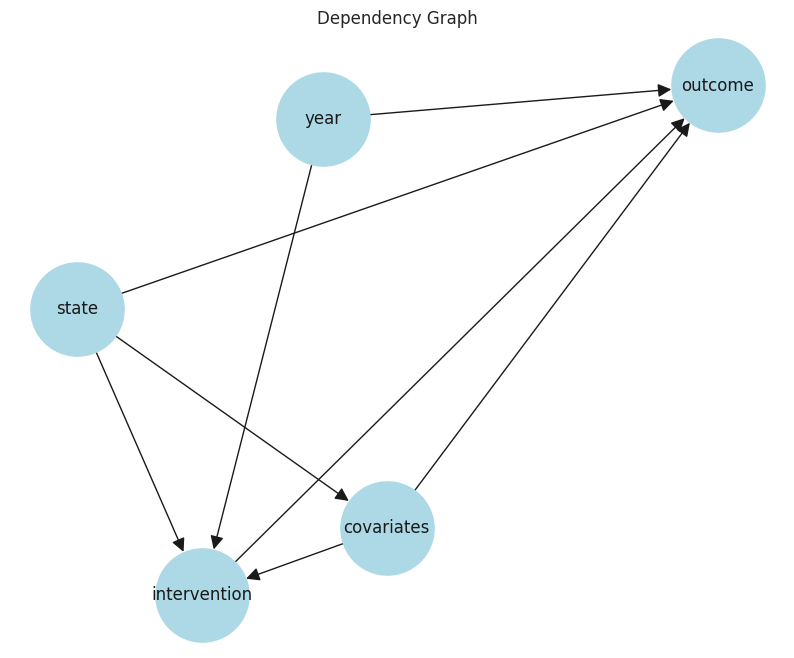

In [60]:


# Create a directed graph
G = nx.DiGraph()

# Define nodes
nodes = ['covariates', 'intervention', 'outcome', 'state', 'year']

# Add nodes to the graph
G.add_nodes_from(nodes)

# Define edges (dependencies)
edges = [
    ('covariates', 'intervention'),
    ('covariates', 'outcome'),
    ('intervention', 'outcome'),
    ('state', 'covariates'),
    ('state', 'intervention'),
    ('state', 'outcome'),
    ('year', 'intervention'),
    ('year', 'outcome'),
]

G.add_edges_from(edges)
fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=4500, node_color='lightblue', 
        arrowsize=20)
plt.title("Dependency Graph")
plt.show()
